In [1]:
from adnmtf import NMF, NTF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics

from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import MVMDS
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import umap
from scipy.spatial import distance_matrix
import hoggorm as ho

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

from mofapy2.run.entry_point import entry_point

import adilsm.adilsm as ilsm

from gfa import gfa_experiments

RESULTS_PATH = './results/'
DATA_PATH = './data/'

adilsm version=0.0.11


Data prep

In [2]:
###############################################################################
# Load Data
# ---------
# Data comes from UCI Digits Data. Contains 6 views and classifications of
# numbers 0-9

Xs, list_digits = load_UCImultifeature()

sample_rate = 1

if sample_rate < 1:
    num_rows = list_digits.shape[0]
    num_rows_to_select = int(num_rows * sample_rate)
    selected_rows = np.random.choice(num_rows, num_rows_to_select, replace=False)

    for i in range(len(Xs)):
        Xs[i] = Xs[i][selected_rows]

    list_digits = list_digits[selected_rows]

list_cell_codes, list_cell_types = pd.factorize(list_digits)

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')


There are 6 views.
There are 2000 observations
The feature sizes are: [76, 216, 64, 240, 47, 6]


In [3]:
Xs_norm = Xs.copy()
for i in range(len(Xs)):
    Xs_norm[i] = Xs[i] - np.mean(Xs[i], axis=0)
    scaler = StandardScaler()
    Xs_norm[i] = scaler.fit_transform(Xs[i])

data_mat = [[None for g in range(1)] for m in range(6)]

for m in range(6):
    data_mat[m][0] = Xs_norm[m]

In [4]:
ent = entry_point()
ent.set_data_matrix(data_mat, likelihoods = ["gaussian" for _ in range(6)])
ent.set_model_options(
    factors = 10, 
    spikeslab_weights = False, 
    ard_weights = True
)
ent.set_train_options(
    convergence_mode = "medium", 
    dropR2 = 0.001, 
    gpu_mode = False, 
    seed = 1
)
ent.build()
ent.run()
model_mofa = ent.model.nodes["Z"].getExpectation()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

In [5]:
model_gfa = gfa_experiments(Xs_norm, K=8, Nrep=100, rotate=False, verbose=1)
# model = gfa_experiments(Xs_norm, K=7, Nrep=10, rotate=False, verbose=1)
# model = gfa_experiments(Xs_norm, K=6, Nrep=10, rotate=False, verbose=1)

Run 1/100: 133 iterations with final cost -1369467.080288
Run 2/100: 134 iterations with final cost -1369375.293004
Run 3/100: 133 iterations with final cost -1369438.807495
Run 4/100: 133 iterations with final cost -1369462.653389
Run 5/100: 133 iterations with final cost -1369479.740768
Run 6/100: 132 iterations with final cost -1369510.939621
Run 7/100: 133 iterations with final cost -1369403.618972
Run 8/100: 132 iterations with final cost -1369483.617769
Run 9/100: 133 iterations with final cost -1369445.797656
Run 10/100: 133 iterations with final cost -1369453.537970
Run 11/100: 133 iterations with final cost -1369483.284217
Run 12/100: 133 iterations with final cost -1369428.155378
Run 13/100: 133 iterations with final cost -1369456.137075
Run 14/100: 132 iterations with final cost -1369534.095624
Run 15/100: 134 iterations with final cost -1369377.623707
Run 16/100: 132 iterations with final cost -1369508.107806
Run 17/100: 132 iterations with final cost -1369537.088937
Run 18

In [6]:
Xs_ism = [None] * 7
Xs_ism[0] = Xs[0].copy()
Xs_ism[1] = Xs[1].copy()

Xs_ism[2] = Xs[2].copy()
Xs_ism[2][Xs_ism[2]<0] = 0

Xs_ism[3] = -Xs[2].copy()
Xs_ism[3][Xs_ism[3]<0] = 0

for i in range(4,len(Xs_ism)):
    Xs_ism[i] = Xs[i-1].copy()


ISM workflow

In [7]:
n_embedding, n_themes = [9,10]

ilsm_result = ilsm.ism(Xs_ism, n_embedding, n_themes, norm_columns=1, update_h_ism=True,
                                    max_iter_mult=200, fast_mult_rules=True, sparsity_coeff=.8)
hv = ilsm_result['HV']
hv_sparse = ilsm_result['HV_SPARSE']
hhii_updated = ilsm_result['HHII']
w4_ism = ilsm_result['W']
h4_ism = ilsm_result['H']
q4_ism = ilsm_result['Q']
Xs_emb = ilsm_result['EMBEDDING']
Xs_norm = ilsm_result['NORMED_VIEWS']

h4_updated_sparse = hv[0].copy()
for h in hv_sparse[1:]:
    h4_updated_sparse = np.vstack((h4_updated_sparse, h))

print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated_sparse), 2))


error ism before straightening:  0.39
Straightening:
iteration 0...
iteration 1...
iteration 2...
iteration 3...
iteration 4...
iteration 5...
iteration 6...
iteration 7...
iteration 8...
iteration 9...
iteration 10...
iteration 11...
iteration 12...
iteration 13...
iteration 14...
iteration 15...
iteration 16...
iteration 17...
iteration 18...
iteration 19...
error ism after straightening:  0.52
condition number(9, 10) =  7.62


Figures

In [8]:
# MDS projection
mds = MDS(n_components=2, random_state=0)
# mds = umap.UMAP(random_state=0, n_jobs=1, min_dist=1)

In [9]:
w4_gfa = model_gfa['Z']
n_marker_genes = list_cell_codes.shape[0]
w4_gfa_mds = mds.fit_transform(normalize(w4_gfa[:n_marker_genes,:], axis=0, norm='l2'))

In [10]:
# 16-16 with .8
# generate N visually distinct colours

# n_comp_pca_mvmds = 12
# n_comp_pca_mvmds = 10
# n_comp_pca_mvmds = 9
n_comp_pca_mvmds = 10

# MVMDS reduction
mvmds = MVMDS(n_components=n_comp_pca_mvmds)
Xs_mvmds_reduced = mvmds.fit_transform(Xs)

# PCA reduction concatenated views 
pca = PCA(n_components=n_comp_pca_mvmds)
Xs_concat = Xs[0]
for X in Xs[1:]:
    Xs_concat = np.hstack((Xs_concat, X))
Xs_pca_reduced = pca.fit_transform(Xs_concat)

# NMF reduction concatenated views 
Xs_concat = Xs_norm[0]
for X in Xs_norm[1:]:
    Xs_concat = np.hstack((Xs_concat, X))
my_nmfmodel = NMF(n_components=n_themes, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=1)
estimator_ = my_nmfmodel.fit_transform(Xs_concat.copy())

w4_nmf = estimator_.w
h4_nmf = estimator_.h

stress = []
w4_ism_mds = mds.fit_transform(w4_ism[:n_marker_genes,:])
stress.append(mds.stress_)
Xs_mvmds_reduced_mds = mds.fit_transform(Xs_mvmds_reduced[:n_marker_genes,:])
stress.append(mds.stress_)
w4_nmf_mds = mds.fit_transform(w4_nmf[:n_marker_genes,:])
stress.append(mds.stress_)
Xs_pca_reduced_mds = mds.fit_transform(Xs_pca_reduced[:n_marker_genes,:])
stress.append(mds.stress_)
w4_mofa = model_mofa
w4_mofa_mds = mds.fit_transform(normalize(w4_mofa[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)
w4_gfa = model_gfa['Z']
w4_gfa_mds = mds.fit_transform(normalize(w4_gfa[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)
print(stress)

[491.4730131240549, 2463.5919172537315, 224757.75543296538, 117997819795.46275, 1863.659405336969, 1642.4790010061445]


10 5.81
0.5743
0.6667
7 4.06
0.4924
0.6103
9 5.84
0.5915
0.6808
4 1.93
0.4355
0.5714
7 2.91
0.3579
0.4588
8 3.59
0.4371
0.581


<function matplotlib.pyplot.show(close=None, block=None)>

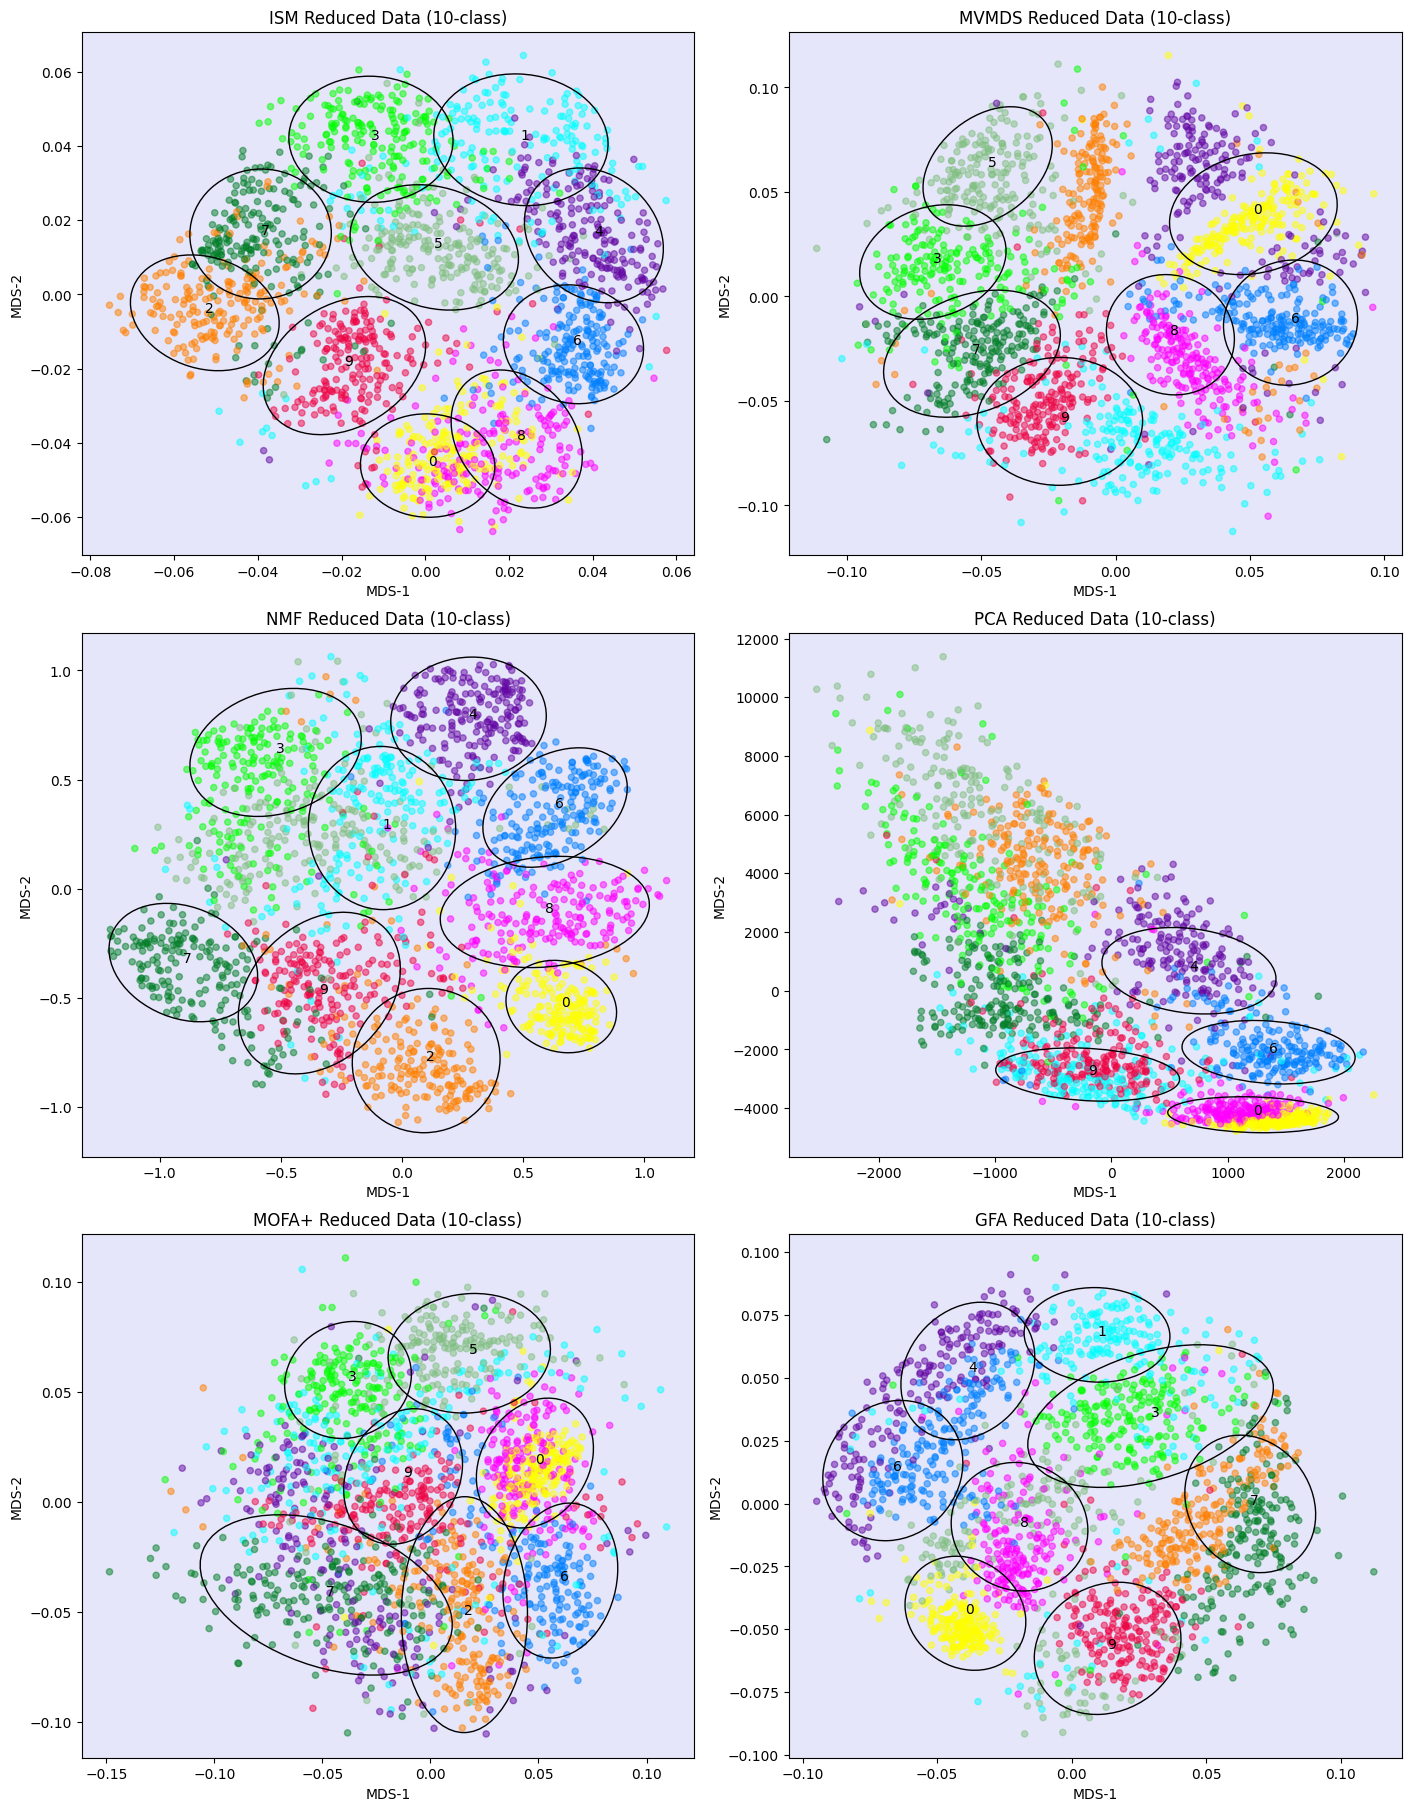

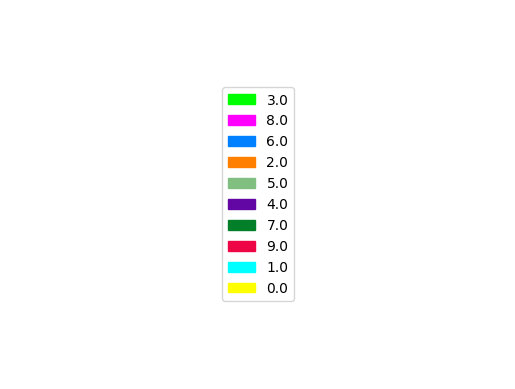

In [11]:
palette = distinctipy.get_colors(10)
cmap = ListedColormap(palette)

patches = []
for code in range(10):
    patches.append(mpatches.Patch(color=palette[code], label=list_cell_types[code]))

# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, cell_label, ax, n_std=2, facecolor='none', **kwargs):
    # Create a plot of the covariance confidence ellipse of `x` and `y`
    # Adapted from [1](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
    
    # Calculate the covariance matrix and the Pearson correlation coefficient
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    # Create the ellipse object
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Scale and translate the ellipse according to the mean and standard deviation of the data
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    # Annotate centroid
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    ax.annotate(int(cell_label), xy=(x_mean, y_mean))

    # Add the ellipse to the axes
    ax.add_patch(ellipse)
    return x_mean, y_mean

# define a function to plot scatter with clusters and confidence ellipses
# define a function to plot scatter with clusters and confidence ellipses
def plot_scatter(x, y, title=None, k=None, ax=None, list_cell_codes=None, skip_ellipse=[], face_color='lavender', **kwargs):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.c_[x, y])
    # Get the cluster labels and centroids
    labels = kmeans.labels_  # Get cluster labels
    labels_matched = np.empty_like(labels)
    unique_labels = np.unique(labels)
    truth_label = np.zeros(len(unique_labels))

    # For each cluster label...
    for l in unique_labels:
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((labels==l)*(list_cell_codes==t)) for t in np.unique(list_cell_codes)]
        truth_label[l] = np.unique(list_cell_codes)[np.argmax(match_nums)]
        labels_matched[labels==l] = truth_label[l]

    ax.scatter(x, y, c=list_cell_codes[:n_marker_genes], cmap=cmap, alpha=0.5, s=20)
    ax.set_title(title)
    ax.set_xlabel("MDS-1")
    ax.set_ylabel("MDS-2")
    ax.set_facecolor(face_color)

    p1 = np.zeros(k)
    p2 = np.zeros(k)
    unique_labels_matched = np.unique(labels_matched)
    xy_mean = np.zeros((len(unique_labels),2))    
    mean_intra_distance = np.zeros(len(unique_labels))
    mean_inter_distance = np.zeros(len(unique_labels))
    flag = np.zeros(len(unique_labels))

    for l in unique_labels_matched:
        indices = np.where(truth_label == l)[0]
        if indices.shape[0] > 1:
            # calculate mean distance inter-clusters pointing to same class
            xy_mean2 = np.zeros((indices.shape[0],2))
            for l2 in range(len(indices)):
                xy_mean2[l2,0] = np.mean(x[labels == indices[l2]])
                xy_mean2[l2,1] = np.mean(y[labels == indices[l2]])
                xy_intra = np.column_stack((x[labels == indices[l2]], y[labels == indices[l2]]))
                D = distance_matrix(xy_intra, xy_intra)
                mean_intra_distance[l] += np.mean(D[D>0])
                    
            D = distance_matrix(xy_mean2, xy_mean2)
            mean_inter_distance[l] = np.mean(D[D>0])
            if mean_inter_distance[l] / mean_intra_distance[l] > 1:
                flag[l] = 1

    n_matched_cell_types = 0
    
    for l in np.unique(labels_matched):
        if not flag[l]:
            p1[l] = np.sum(labels_matched[labels_matched==l] == list_cell_codes[labels_matched==l])
            p2[l] = p1[l] / np.sum(list_cell_codes == l)
            p1[l] /=  np.sum(labels_matched == l)
            # if p1[l] > .5 and p2[l] > .5:
            if p2[l] > .5:
                n_matched_cell_types += 1
                xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, n_std=2, edgecolor='black')
            else:
                p1[l] = 0
                p2[l] = 0
        else:
            xy_mean[l,0] = 0
            xy_mean[l,1] = 0
    
    inter_distance = distance_matrix(xy_mean, xy_mean)
    mean_inter_distance = np.mean(inter_distance[inter_distance>0])
    norm_distance = np.max(inter_distance) - inter_distance
    # print(p1)
    # print(p2)
    print(n_matched_cell_types, round(np.sum(p1*p2),2))
    print(round(adjusted_rand_score(labels_matched, list_cell_codes),4)) 
    print(round(normalized_mutual_info_score(list_cell_codes, labels_matched),4)) 
    
fig, ax = plt.subplots(3, 2, figsize=(14, 18), constrained_layout=True)

face_color = 'lavender'
k=10

plot_scatter(w4_ism_mds[:, 0], w4_ism_mds[:, 1], title="ISM Reduced Data (10-class)", k=k, ax=ax[0,0], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(Xs_mvmds_reduced_mds[:, 0], Xs_mvmds_reduced_mds[:, 1], title="MVMDS Reduced Data (10-class)", k=k, ax=ax[0,1], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_nmf_mds[:, 0], w4_nmf_mds[:, 1], title="NMF Reduced Data (10-class)", k=k, ax=ax[1,0], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(Xs_pca_reduced_mds[:, 0], Xs_pca_reduced_mds[:, 1], title="PCA Reduced Data (10-class)", k=k, ax=ax[1,1], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_mofa_mds[:, 0], w4_mofa_mds[:, 1], title="MOFA+ Reduced Data (10-class)", k=k, ax=ax[2,0], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_gfa_mds[:, 0], w4_gfa_mds[:, 1], title="GFA Reduced Data (10-class)", k=k, ax=ax[2,1], list_cell_codes=list_cell_codes, skip_ellipse=[])

plt.show

# Add the legend to a new figure
fig2, ax2 = plt.subplots()
ax2.legend(handles=patches, loc='center')
plt.gca().set_axis_off()
ax2.set_facecolor(face_color)
plt.show